In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

sns.set_theme()

# Import buildbot nightly-value run 00437

In [2]:
data_dirty = pd.read_csv(filepath_or_buffer='./00437.-r_integration-nightly-value.2023-03-01_00-26-24.table.csv',sep='\t',header=2,index_col=0)

In [3]:
data_in = data_dirty.copy()

#Drop tasks with status TIMEOUT and unknown
# We cannot train on them, because we do not know the stats
# at the time when they would have finished
columns_false = data_in[data_in.status.str.startswith('false', na=False)]
columns_true = data_in[data_in.status.str.startswith('true', na=False)]

data_clean = pd.concat([columns_false,columns_true])

#Drop completely empty columns
# (such as Solver time when evaluating a value analysis result)
data_clean = data_clean.dropna(axis='columns',how='all')

# 1) Baseline Linear Regression: CPU Time + Number of iterations

## Select metrics to analyze

In [4]:
data_in = data_clean.copy()

data_1 = data_in[['CPU Time (s)','Number of iterations']]

#Drop rows that have NaN entries
data_1 = data_1.dropna()

## Regression Pipeline

In [5]:
x_sr = data_1['Number of iterations']
y_sr = data_1['CPU Time (s)']

LR = LinearRegression()
LR.fit(x_sr.values.reshape(-1,1),y_sr.values)

LinearRegression()

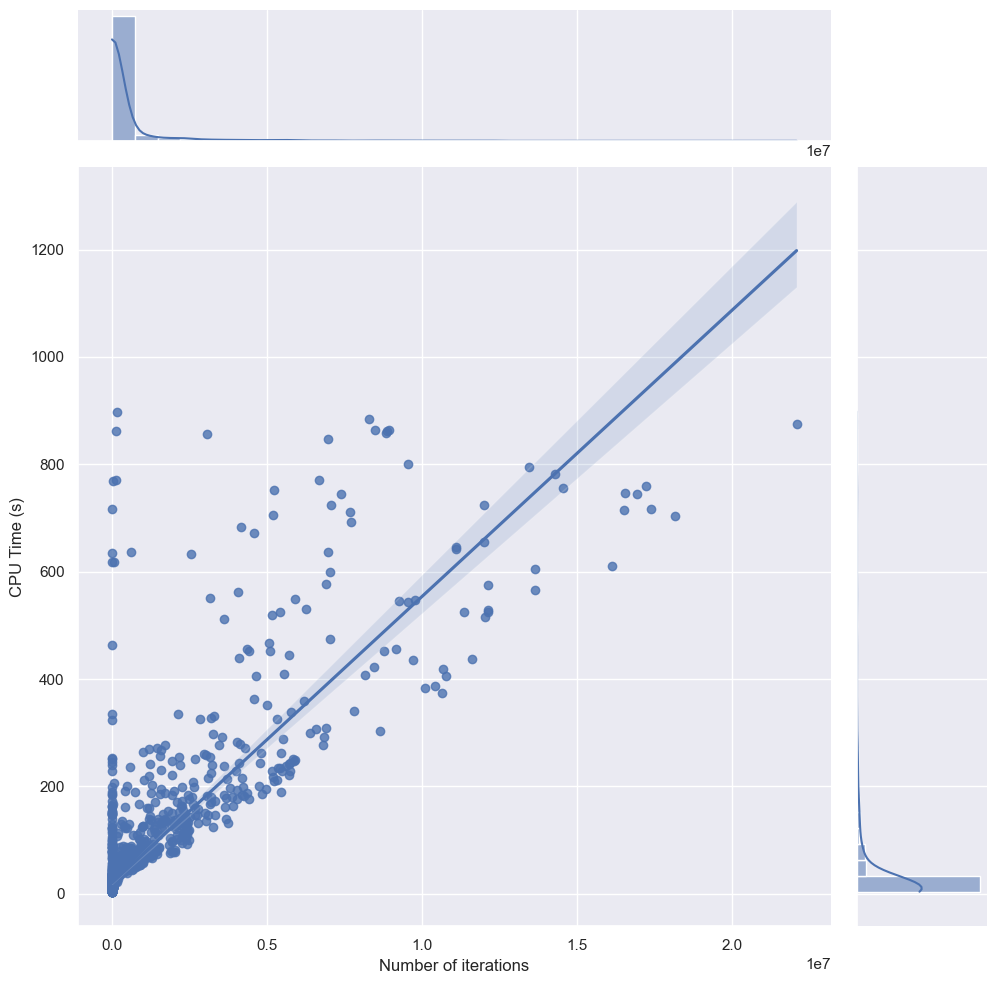

In [6]:
regrplot = sns.jointplot(data=data_1, x="Number of iterations", y="CPU Time (s)", height=10, marginal_kws={"bins":30,}, kind="reg");
#regrplot.savefig('1_correlation.pdf')

## Residuals

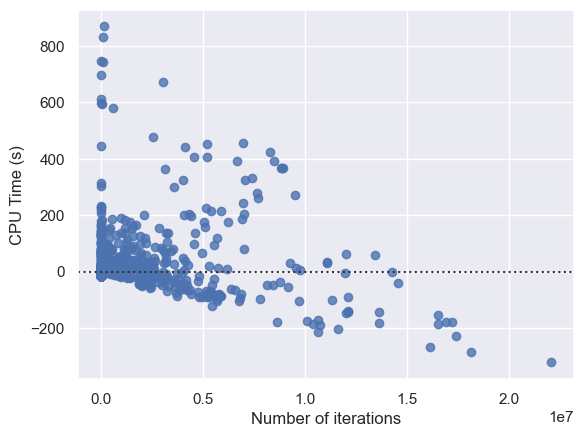

In [17]:
residplot = sns.residplot(data=data_1, x="Number of iterations", y="CPU Time (s)");
#residplot.get_figure().savefig('2_residuals.pdf')

## 5-Fold Cross Validation

In [8]:
scores = cross_val_score(LR, x_sr.values.reshape(-1,1), y_sr.values, cv=5)
print("Mean r2 = %0.2f and standard deviation = %0.2f:\nIndividual r2 values: %s" % (scores.mean(), scores.std(), scores))

Mean r2 = -13.48 and standard deviation = 28.18:
Individual r2 values: [  0.78785148   0.58218299   0.60896076 -69.84601617   0.46400649]


# 2) Multiple Linear Regression: Manual Feature Selection

## Select metrics to analyze

In [9]:
data_in = data_clean.copy()

#Manually chosen features
data_2 = data_in[['CPU Time (s)','Number of iterations','Avg size of partitions','Size of reached set','Number of unique precision increments']]

#Drop rows that have NaN entries in chosen features
data_2 = data_2.dropna()

## Regression Pipeline

In [10]:
#CPU time is dependent variable
x_mr_df = data_2.drop(['CPU Time (s)'],axis=1)
y_mr_df = data_2['CPU Time (s)']
x_mr = x_mr_df.values
y_mr = y_mr_df.values

LR = LinearRegression()
pipeline = make_pipeline(StandardScaler(), LR)

## 5-Fold Cross Validation

In [11]:
scores = cross_val_score(pipeline, x_mr, y_mr, cv=5)
print("Mean R2 = %0.2f and standard deviation = %0.2f:\nIndividual R2 values: %s" % (scores.mean(), scores.std(), scores))

Mean R2 = -1.07 and standard deviation = 3.26:
Individual r2 values: [ 0.77468396  0.50903707  0.71639847 -7.57480248  0.20317295]


# 3) Multiple Linear Regression: Sequential Feature Selection

## Select metrics to analyze

In [12]:
data_in = data_clean.copy()

#Drop columns that are text: status, verdict (Unnamed: 1), Wall Time (s)
#Drop columns that are non-deterministic: Memory according to Martin
#Drop columns with discrete values: 'Number of target states'
data_3 = data_in.drop(['status','Unnamed: 1','Wall Time (s)','Automaton transfer successors','Memory (MB)','Number of target states'],axis=1,errors='ignore')

#Drop rows that have NaN entries in chosen features
data_3 = data_3.dropna()

## Regression Pipeline

In [13]:
#CPU time is dependent variable
x_mr_df = data_3.drop(['CPU Time (s)'],axis=1)
y_mr_df = data_3['CPU Time (s)']
x_mr = x_mr_df.values
y_mr = y_mr_df.values

LR =  LinearRegression()
pipeline = make_pipeline(StandardScaler(), LR)

## Sequential Feature Selection

In [14]:
sfs_forward = SequentialFeatureSelector(
    pipeline, n_features_to_select=5, direction="forward"
).fit(x_mr, y_mr)

feature_names = x_mr_df.columns.values
print(
    "Features selected by forward sequential selection:\n"
    f"{feature_names[sfs_forward.get_support()]}"
)

Features selected by forward sequential selection:
['Max size of waitlist' 'Number of unique precision increments'
 'Avg. size of reached set before ref.' 'Number of functions'
 'Number of reached locations']


## 5-Fold Cross Validation

In [15]:
x_selected = x_mr_df[feature_names[sfs_forward.get_support()]]

scores = cross_val_score(pipeline, x_selected, y_mr, cv=5)
print("Mean R2 = %0.2f and standard deviation = %0.2f:\nIndividual R2 values: %s" % (scores.mean(), scores.std(), scores))

Mean R2 = 0.54 and standard deviation = 0.15:
Individual r2 values: [0.72016752 0.51497614 0.50793935 0.67497086 0.29355133]
